# Startups operations/close predictions

**Цель проекта:**
- разработать модель для предсказания успешности стартапа (закроется или нет). 

**Описание данных:**<br>
Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

**План работ:**<br>
- загрузка и ознакомление с данными
- предварительная обработка
- полноценный разведочный анализ
- разработка новых синтетических признаков
- проверка на мультиколлинеарность
- отбор финального набора обучающих признаков
- выбор и обучение моделей
- итоговая оценка качества предсказания лучшей модели
- анализ важности ее признаков

In [1]:
import sys
sys.path.append(r'C:\Users\Наташа\AppData\Roaming\Python\Python39\Scripts')
!pip install --user phik -q
!pip install --upgrade --user catboost -q
!pip install --user shap -q

In [2]:
!pip install --user --upgrade  scipy phik -q

In [3]:
!pip install --user --upgrade scikit-learn -q

In [4]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import f1_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import BaseEstimator, TransformerMixin

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


#import shap

from warnings import simplefilter
from catboost import Pool, CatBoostClassifier, cv

C:\Users\Наташа\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Наташа\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [5]:
pd.set_option('chained_assignment', None)

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [6]:
import shap

## Загрузка данных

In [7]:
try:
    data_train = pd.read_csv('datasets/kaggle_startups_train_27042024.csv', sep = ',', parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])
    data_test = pd.read_csv('datasets/kaggle_startups_test_27042024.csv', sep = ',', parse_dates=['founded_at', 'first_funding_at',  'last_funding_at'])
except FileNotFoundError:
    print('Файл не найден. Необходимо проверить путь к файлу')
except Exception:
    print('Файл не загрузился')

In [8]:
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaT


In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  42445 non-null  float64       
 3   status             52514 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          4915 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [10]:
data_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,6209


Загрузили данные из двух источников.<br>
В таблице **data_train** 52514 строк, есть пропуски. Типы данных после преобразования соответствуют. Таблица содержит данные о названии и категории стартапа, сумме финансирования, географии стартапа, количестве раундов финансирования, датах основания и финансирования, дате закрытия, а также целевой признак: статус стартапа (закрыт или действующий). <br>
В таблице **data_test** 13125 строк строк, пропуски есть, типы данных соответствуют. Нет целевого признака, при этом есть продолжительность существования стартапа в днях.

##  Предобработка данных и исследовательский анализ

### Исследование таблицы data_train

In [11]:
#Проверка на пропуски в данных
data_train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5501
state_code            6762
region                6358
city                  6358
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

Пропуски есть, особенно много их в числовом поле funding_total_usd, их нужно будет заполнить.

In [12]:
# проверка на явные дубликаты
data_train.duplicated().sum()

0

Дубликатов в таблице data_train нет.<br>

In [13]:
# проверка на неявные дубликаты
data_train['name'].duplicated().sum()

0

In [14]:
data_train['status'].value_counts()

status
operating    47599
closed        4915
Name: count, dtype: int64

Есть дисбаланс классов. Стартапов со статусом closed гораздо меньше, чем со статусом operating. Нужно будет учесть при построении модели.

In [15]:
data_train['country_code'].value_counts()

country_code
USA    29701
GBR     2925
CAN     1540
IND     1276
CHN     1240
       ...  
PSE        1
SEN        1
UZB        1
GRD        1
ZMB        1
Name: count, Length: 134, dtype: int64

В столбцах неявных дубликатов обнаружено не было.

### Анализ количественных признаков

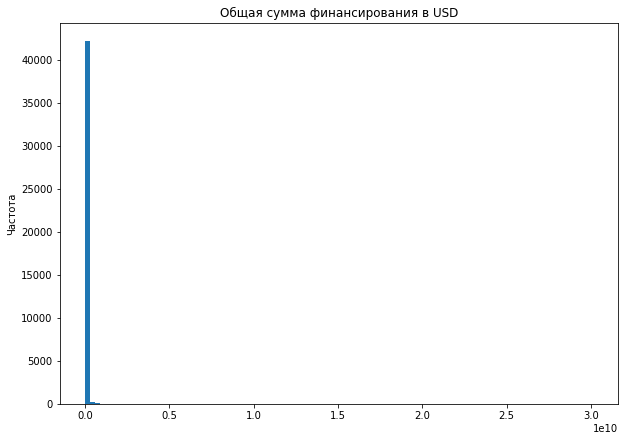

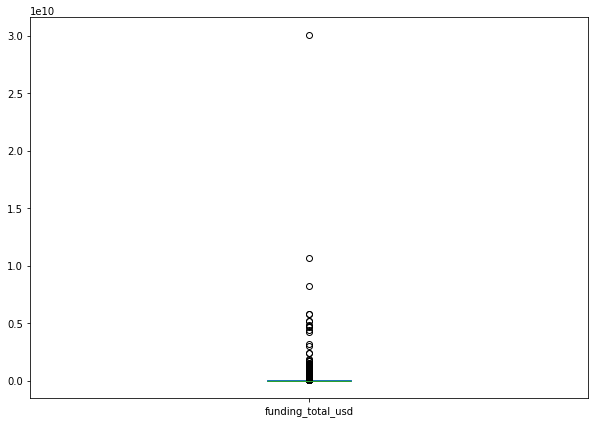

In [16]:
data_train.plot(y='funding_total_usd',title='Общая сумма финансирования в USD', kind='hist' ,bins=100, figsize = (10,7), legend = False)
plt.ylabel("Частота");
data_train.plot(y='funding_total_usd', kind='box' , figsize = (10,7), legend = False);

По признаку "Общая сумма финансирования в USD" распределение далеко от нормального, много пропусков, много выбросов.<br>
Рассмотрим внимательнее на стартапы с меньшей суммой финансирования: до 10000000.

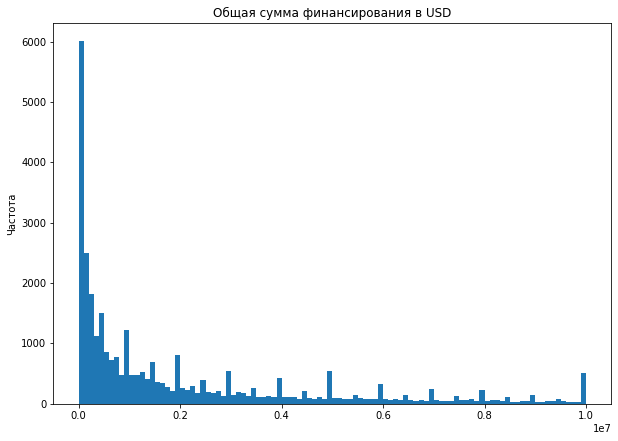

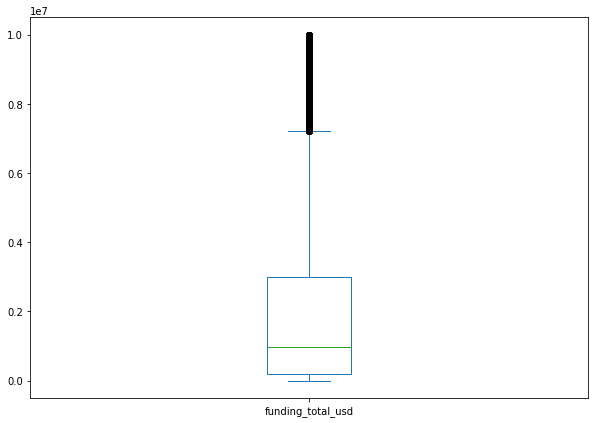

In [17]:
data_train.query('funding_total_usd <= 10000000').plot(y='funding_total_usd',title='Общая сумма финансирования в USD', kind='hist' ,bins=100, figsize = (10,7), legend = False)
plt.ylabel("Частота");
data_train.query('funding_total_usd <= 10000000').plot(y='funding_total_usd', kind='box' , figsize = (10,7), legend = False);

In [18]:
data_train.describe()

,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
count,4.244500e+04,52514.000000,52514,52514,52514,4915
mean,1.824826e+07,1.740679,2008-11-04 08:35:44.342460928,2011-07-17 04:55:32.779830016,2012-06-27 16:46:47.936931072,2012-01-17 17:10:42.360121856
min,1.000000e+00,1.000000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-12-19 00:00:00
25%,3.360000e+05,1.000000,2006-09-28 00:00:00,2009-10-12 00:00:00,2011-02-01 00:00:00,2009-10-01 12:00:00
50%,2.000000e+06,1.000000,2010-10-01 00:00:00,2012-07-23 00:00:00,2013-08-30 00:00:00,2012-10-01 00:00:00
75%,1.000000e+07,2.000000,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00,2015-04-30 12:00:00
max,3.007950e+10,19.000000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2017-11-12 00:00:00
std,1.871217e+08,1.374544,NaN,NaN,NaN,NaN


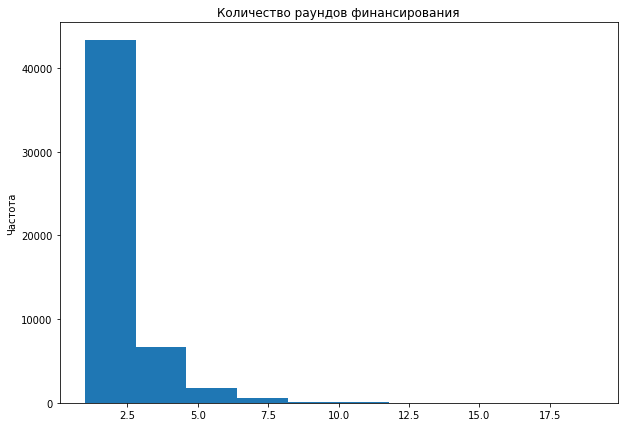

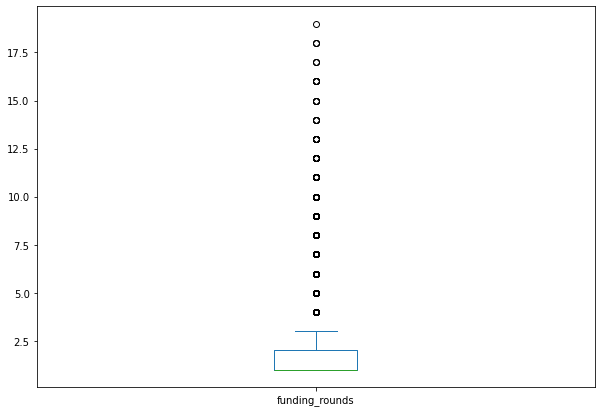

In [19]:
data_train.plot(y='funding_rounds',title='Количество раундов финансирования', kind='hist' ,bins=10, figsize = (10,7), legend = False)
plt.ylabel("Частота");
data_train.plot(y='funding_rounds', kind='box' , figsize = (10,7), legend = False);

Распределение "Количество раундов финансирования" не очень похоже на нормальное. Есть выбросы.<br>
В основном есть 1-2 раунда финансирования, максимально 19.<br>

In [20]:
data_train['funding_rounds'].value_counts()

funding_rounds
1     33488
2      9815
3      4450
4      2189
5      1168
6       616
7       341
8       175
9       109
10       63
11       46
12       22
13        9
16        6
15        5
14        5
17        3
18        3
19        1
Name: count, dtype: int64

### Анализ категориальных переменных

In [21]:
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaT


In [22]:
data_train['category_list'].unique()

array(['Online Reservations|Restaurants',
       'Manufacturing|Medical|Medical Devices', 'Biotechnology', ...,
       'Gambling|Games|Online Gaming|Sports',
       'Aerospace|Mobile|Transportation|Travel',
       'Online Rental|Parking|Price Comparison'], dtype=object)

Категорий в столбце category_list очень много, в т.ч. в каждой строке наблюдается деление на подкатегории. Укрупним до первой/главной категории.

In [23]:
data_train['category_first']=data_train['category_list'].str.split('|').str[0]
data_test['category_first']=data_test['category_list'].str.split('|').str[0]

In [24]:
data_train['category_first'].nunique()

707

In [25]:
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category_first
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaT,Online Reservations
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,Manufacturing
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,Biotechnology
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,Health Care
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaT,Manufacturing


In [26]:
data_train['category_first'].value_counts().head(50)

category_first
Biotechnology             3592
Software                  3322
E-Commerce                2172
Advertising               1925
Curated Web               1746
Mobile                    1396
Analytics                 1314
Apps                      1184
Health Care               1134
Enterprise Software       1110
Clean Technology          1106
Games                     1014
Health and Wellness        956
Hardware + Software        876
Finance                    873
Education                  800
Manufacturing              688
Consulting                 566
Internet                   505
Cloud Computing            495
Entertainment              449
Semiconductors             427
Android                    404
Social Media               404
Hospitality                384
Real Estate                383
Fashion                    374
Automotive                 369
Security                   362
Big Data                   334
Design                     312
Business Services       

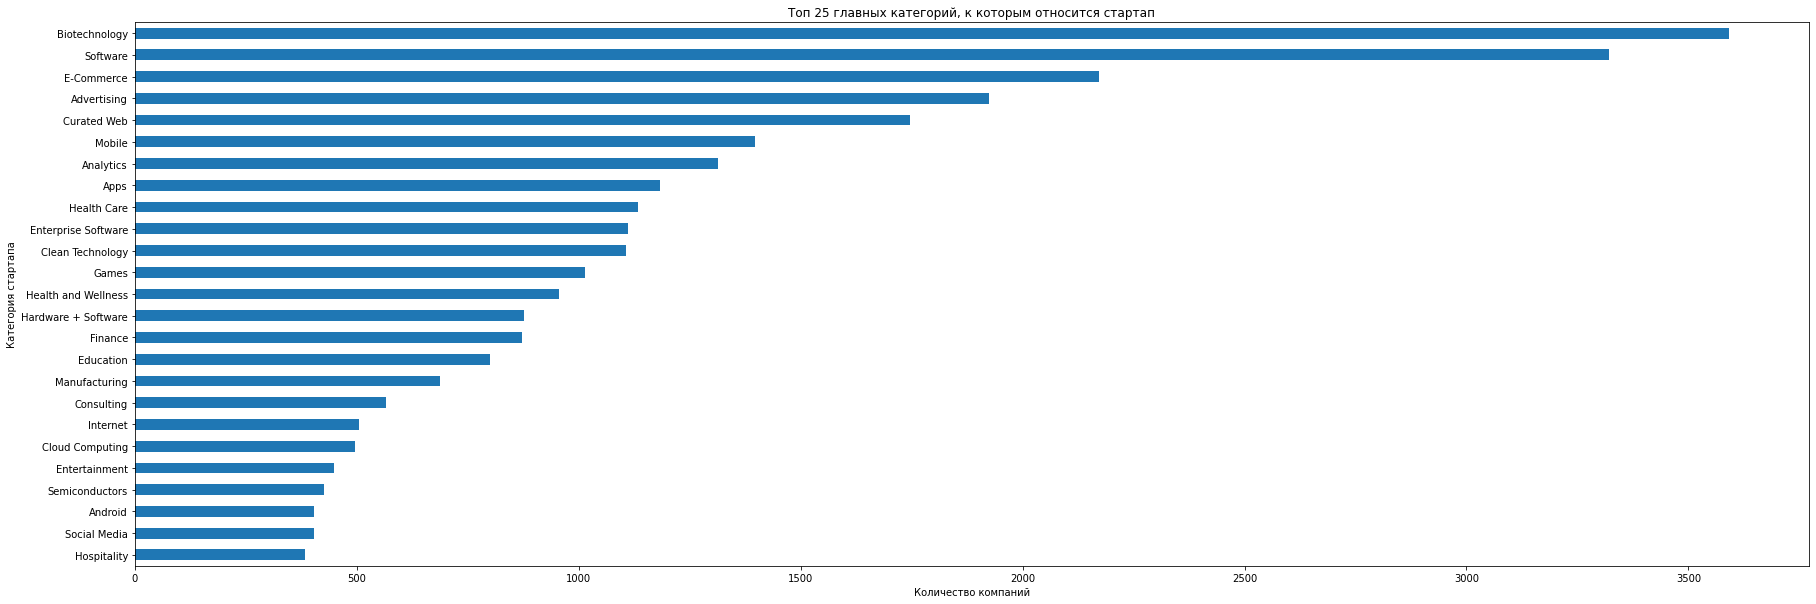

In [27]:
data_train.pivot_table(index = 'category_first', aggfunc = 'count')['name'].sort_values().tail(25).plot(y='Количество компаний',title='Топ 25 главных категорий, к которым относится стартап', kind='barh' , figsize = (30,10), legend = False)
plt.ylabel("Категория стартапа");
plt.xlabel("Количество компаний");

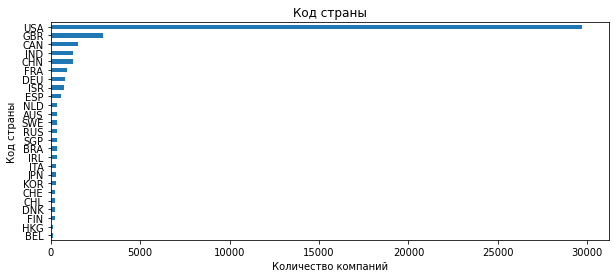

In [28]:
data_train.pivot_table(index = 'country_code', aggfunc = 'count')['name'].sort_values().tail(25).plot(y='Количество компаний',title = 'Код страны', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Код страны");
plt.xlabel("Количество компаний");

In [29]:
data_train['country_code'].unique()

array(['CHE', 'USA', nan, 'GBR', 'RUS', 'ESP', 'FRA', 'SWE', 'IND', 'KOR',
       'AUS', 'TWN', 'CHN', 'HUN', 'CAN', 'FIN', 'BRA', 'EGY', 'PRT',
       'ISR', 'CHL', 'SVK', 'NLD', 'ARG', 'ARE', 'JPN', 'IRL', 'DEU',
       'LBN', 'EST', 'IDN', 'BEL', 'MEX', 'DNK', 'ITA', 'GRC', 'ROM',
       'TUR', 'SGP', 'SAU', 'MYS', 'NGA', 'QAT', 'VNM', 'BGR', 'GHA',
       'UGA', 'JOR', 'AUT', 'PAK', 'NZL', 'HKG', 'ZAF', 'LVA', 'NOR',
       'HRV', 'VEN', 'PER', 'LUX', 'SVN', 'POL', 'PHL', 'NIC', 'CZE',
       'ISL', 'PAN', 'URY', 'BGD', 'MCO', 'GTM', 'THA', 'TTO', 'UKR',
       'KEN', 'CRI', 'DZA', 'LTU', 'CYM', 'MUS', 'BLR', 'SLV', 'COL',
       'MLT', 'PSE', 'BLZ', 'CYP', 'MMR', 'MKD', 'KHM', 'GIB', 'SRB',
       'DOM', 'BWA', 'BLM', 'PRY', 'BMU', 'TAN', 'LIE', 'GRD', 'UZB',
       'GEO', 'SEN', 'ALB', 'ECU', 'MOZ', 'LKA', 'LAO', 'TUN', 'HND',
       'ZWE', 'BAH', 'MDA', 'MAF', 'BHR', 'AZE', 'MAR', 'KWT', 'IRN',
       'GGY', 'KNA', 'PRI', 'OMN', 'KAZ', 'JAM', 'NPL', 'ARM', 'TGO',
       'RWA', '

Неявных дубликатов не обнаружено. Кодов страны не так много, в связи с этим можно включить их в модель классификации.

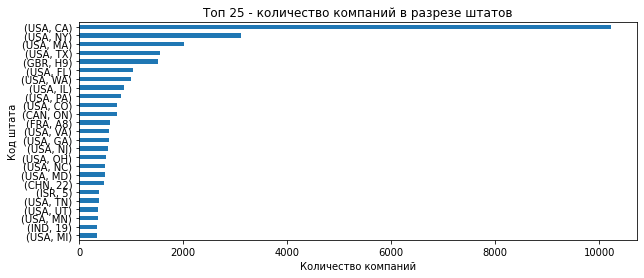

In [30]:
data_train.pivot_table(index =['country_code', 'state_code'], aggfunc = 'count')['name'].sort_values().tail(25).plot(y='Количество компаний',title = 'Топ 25 - количество компаний в разрезе штатов', kind='barh' , figsize = (10,4), legend = False)
plt.ylabel("Код штата");
plt.xlabel("Количество компаний");

Большинство компаний-стартапов запущено в США.

### Обработка данных и синтез новых признаков

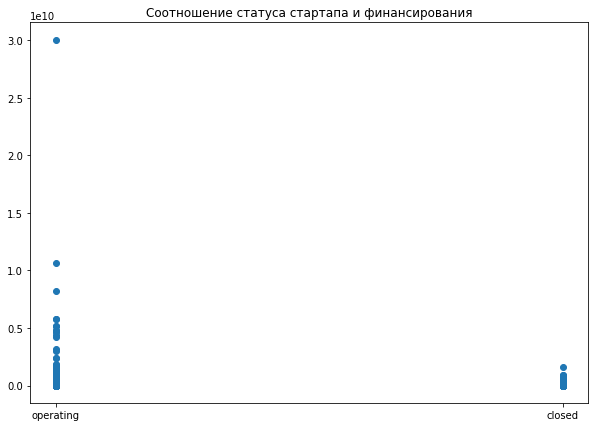

In [31]:
plt.figure(figsize = (10, 7))

p1 = plt.scatter(x = data_train['status'], y = data_train['funding_total_usd'])
plt.title('Соотношение статуса стартапа и финансирования')

plt.show();

С какого-то значения 'funding_total_usd' все стартапы относятся к категории operating. Т.е. чем больше финансирование, тем меньше риск быть закрытым. Найдем максимальный объем финансирования для закрытых стартапов и введем новый признак **большой объем финансирования** high_funding_total.

In [32]:
data_train['high_funding_total'] = data_train['funding_total_usd'].apply(lambda x:1 if x>=1570000000 else 0)

In [33]:
data_test['high_funding_total'] = data_test['funding_total_usd'].apply(lambda x:1 if x>=1570000000 else 0)

In [34]:
data_train['high_funding_total'].value_counts()

high_funding_total
0    52494
1       20
Name: count, dtype: int64

In [35]:
data_train[data_train['status']=='closed']['funding_total_usd'].max()

1567504319.0

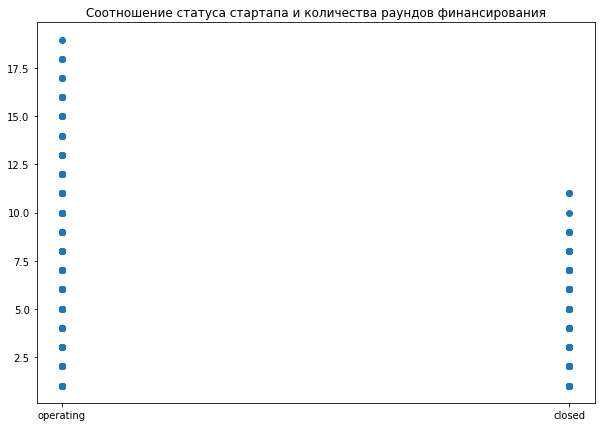

In [36]:
plt.figure(figsize = (10, 7))

p1 = plt.scatter(x = data_train['status'], y = data_train['funding_rounds'])
plt.title('Соотношение статуса стартапа и количества раундов финансирования')

plt.show();

Заполним пропуски в столбце 'funding_total_usd' медианным значением.

In [37]:
data_train['funding_total_usd'] = data_train['funding_total_usd'].fillna(data_train['funding_total_usd'].median())
data_test['funding_total_usd'] = data_test['funding_total_usd'].fillna(data_test['funding_total_usd'].median())

In [38]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                52513 non-null  object        
 1   category_list       50049 non-null  object        
 2   funding_total_usd   52514 non-null  float64       
 3   status              52514 non-null  object        
 4   country_code        47013 non-null  object        
 5   state_code          45752 non-null  object        
 6   region              46156 non-null  object        
 7   city                46156 non-null  object        
 8   funding_rounds      52514 non-null  int64         
 9   founded_at          52514 non-null  datetime64[ns]
 10  first_funding_at    52514 non-null  datetime64[ns]
 11  last_funding_at     52514 non-null  datetime64[ns]
 12  closed_at           4915 non-null   datetime64[ns]
 13  category_first      50049 non-null  object    

Пропуски заполнены.

Заполним пропуски  в столбце **'closed_at'** датой выгрузки 2018-01-01 и рассчитаем **lifetime** для тренировочных данных.

In [39]:
data_train['closed_at'] = data_train['closed_at'].fillna(pd.to_datetime('2018-01-01'))

In [40]:
data_train['lifetime'] =  (data_train['closed_at'] - data_train['founded_at']).dt.days

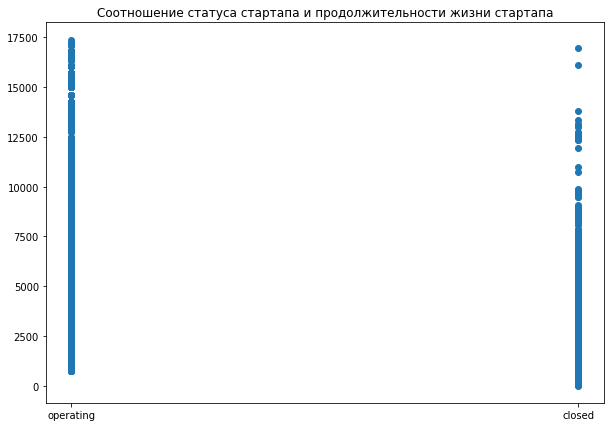

In [41]:
plt.figure(figsize = (10, 7))

p1 = plt.scatter(x = data_train['status'], y = data_train['lifetime'])
plt.title('Соотношение статуса стартапа и продолжительности жизни стартапа')

plt.show();

In [42]:
data_train[data_train['status']=='operating']['lifetime'].min()

731

In [43]:
data_train[(data_train['status']=='closed')&(data_train['lifetime']>13500)]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category_first,high_funding_total,lifetime
9204,AEA,NaN,100000.0,closed,NaN,NaN,NaN,NaN,1,1970-02-05,2014-10-05,2014-10-05,2016-07-04,NaN,0,16951
9488,EvergreenHealth,Health Care,5850000.0,closed,USA,WA,Seattle,Kirkland,1,1972-01-01,2014-04-01,2014-04-01,2016-02-26,Health Care,0,16127
33890,Harper Love Adhesive,NaN,2000000.0,closed,USA,NC,Charlotte,Charlotte,1,1978-01-01,2014-04-28,2014-04-28,2015-09-20,NaN,0,13776


In [44]:
data_train[(data_train['status']=='closed')&(data_train['lifetime']<730)]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category_first,high_funding_total,lifetime
16,Salesjob,NaN,2000000.0,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2014-11-02,NaN,0,670
24,Savasti,NaN,2000000.0,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-02-27,NaN,0,422
78,Efficient Photon,NaN,2000000.0,closed,NaN,NaN,NaN,NaN,1,2011-03-10,2011-09-22,2011-09-22,2012-10-22,NaN,0,592
98,WhipCar,Automotive|Online Rental,2000000.0,closed,GBR,H9,London,London,1,2009-01-01,2009-01-01,2009-01-01,2010-09-17,Automotive,0,624
142,Culhanimal Productions,NaN,25000.0,closed,NaN,NaN,NaN,NaN,1,2014-11-10,2015-01-12,2015-01-12,2016-06-22,NaN,0,590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52348,Smallaa,Facebook Applications|Interest Graph|Networkin...,3000000.0,closed,USA,CA,SF Bay Area,San Jose,1,2008-01-01,2008-03-01,2008-03-01,2009-05-11,Facebook Applications,0,496
52349,Localmind,Curated Web|Facebook Applications|Local Based ...,650206.0,closed,USA,CA,SF Bay Area,San Francisco,2,2010-12-12,2011-01-10,2011-07-13,2012-07-12,Curated Web,0,578
52363,Spotplex,Curated Web,450000.0,closed,USA,CA,SF Bay Area,Santa Clara,1,2007-02-01,2007-01-01,2007-01-01,2008-04-27,Curated Web,0,451
52403,LeftStuff,Software|Technology|Video,86120.0,closed,NaN,NaN,NaN,NaN,1,2014-12-17,2014-12-22,2014-12-22,2016-05-16,Software,0,516


Введем новый признак: **минимальная продолжительность жизни стартапа lifetime_min**
Если рассмотреть соотношение открытых/закрытых стартапов, то увидим, что менее 730 дней, т.е. 2 лет открытых стартапов нет. В связи с этим разделим продолжительность: до 730 и после 730 дней.

In [45]:
data_train['lifetime_min'] = data_train['lifetime'].apply(lambda x:1 if x<=730 else 0)
data_test['lifetime_min'] = data_test['lifetime'].apply(lambda x:1 if x<=730 else 0)

Введем признак **разница между первым финансированием и основанием delta_first_funding**.

In [46]:
data_train['delta_first_funding'] = (data_train['first_funding_at'] - data_train['founded_at']).dt.days
data_test['delta_first_funding'] = (data_test['first_funding_at'] - data_test['founded_at']).dt.days

Введем еще один признак **разница между последним и первым финансированием delta_funding**

In [47]:
data_train['delta_funding'] = (data_train['last_funding_at'] - data_train['first_funding_at']).dt.days
data_test['delta_funding'] = (data_test['last_funding_at'] - data_test['first_funding_at']).dt.days

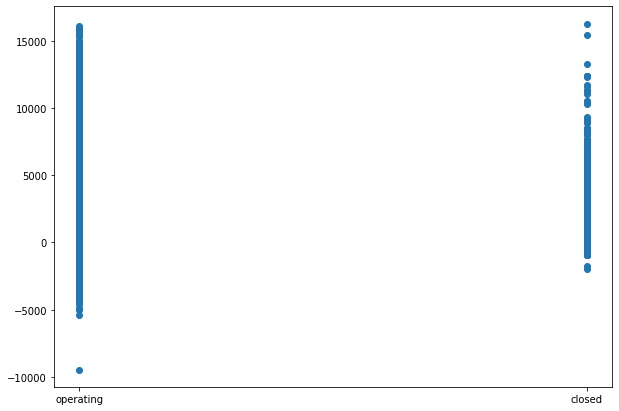

In [48]:
plt.figure(figsize = (10, 7))

p1 = plt.scatter(x = data_train['status'], y = data_train['delta_first_funding'])
plt.title = 'Соотношение между статусом и разницей между первым финансированием и датой основания стартапа'

plt.show();

## Корреляционный анализ

Признаков и строк в исходном датасете много, в связи с этим выберем произвольно 1000 и посмотрим корреляцию.

In [49]:
# sample(1000) используем для ограничения строк
phik_train = data_train.sample(1000).phik_matrix(interval_cols = ['funding_total_usd', 'funding_rounds','high_funding_total','lifetime','delta_first_funding','delta_funding'])

C:\anaconda3\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable high_funding_total for analysis 1. Dropping this column
  warnings.warn(


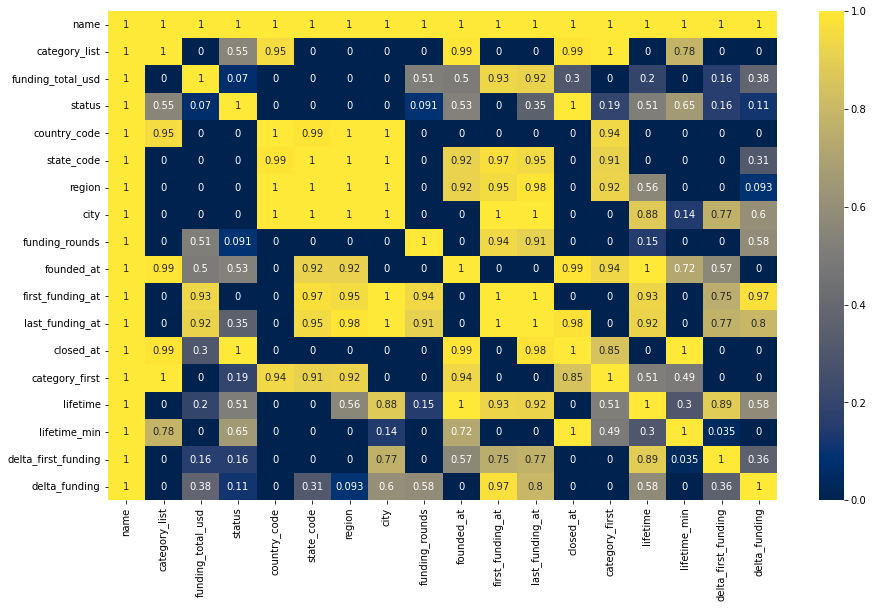

In [50]:
fig, ax = plt.subplots(figsize=(15,9));
sns.heatmap(phik_train, annot=True, cmap='cividis', ax = ax);

Есть столбцы с пропусками, по ним корреляция отображается некорректно.<br>
Есть столбцы, где только уникальные значения (name), по ним корреляция 1.<br>
По данной таблице видна связь статуса и факторов: категории, даты основания, продолжительности жизни стартапа.

In [51]:
phik_x_train = data_train[['country_code','funding_rounds','funding_total_usd','lifetime','category_first','lifetime_min','delta_first_funding','delta_funding','status']].phik_matrix(interval_cols = ['funding_total_usd', 'funding_rounds','high_funding_total','high_funding_rounds','lifetime','delta_first_funding','delta_funding'])

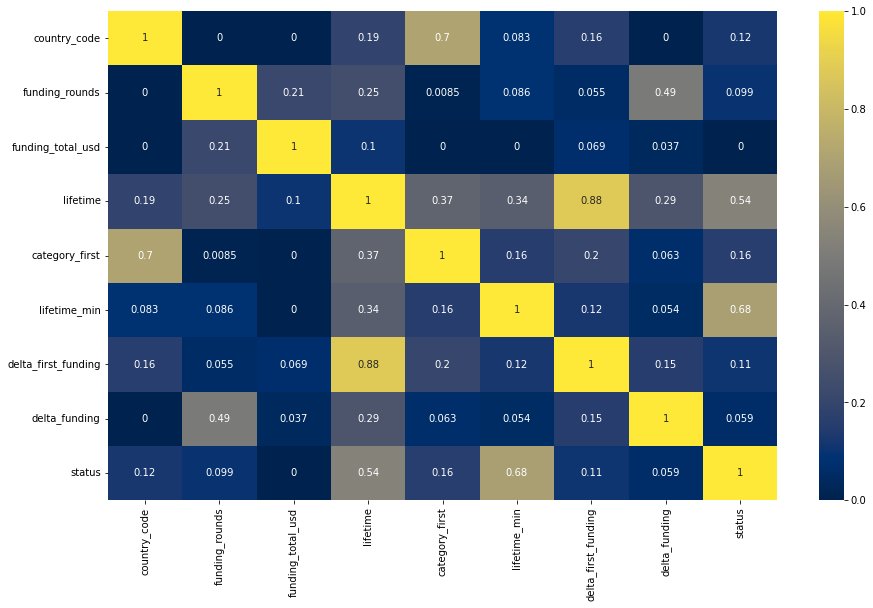

In [52]:
fig, ax = plt.subplots(figsize=(15,9));
sns.heatmap(phik_x_train, annot=True, cmap='cividis', ax = ax);

Подробнее рассмотрим столбцы, которые мы собираемся использовать в модели.<br>
Между lifetime и delta_first_funding наблюдаем сильную зависимость.

## Использование пайплайнов

In [53]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [54]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   name                 52513 non-null  object        
 1   category_list        50049 non-null  object        
 2   funding_total_usd    52514 non-null  float64       
 3   status               52514 non-null  object        
 4   country_code         47013 non-null  object        
 5   state_code           45752 non-null  object        
 6   region               46156 non-null  object        
 7   city                 46156 non-null  object        
 8   funding_rounds       52514 non-null  int64         
 9   founded_at           52514 non-null  datetime64[ns]
 10  first_funding_at     52514 non-null  datetime64[ns]
 11  last_funding_at      52514 non-null  datetime64[ns]
 12  closed_at            52514 non-null  datetime64[ns]
 13  category_first       50049 non-

In [55]:
X_train = data_train[['country_code','funding_rounds','funding_total_usd','lifetime','category_first','lifetime_min','delta_first_funding','delta_funding']]#.iloc[0:10000]
y_train = data_train['status']#[0:10000]
X_test = data_test[['country_code','funding_rounds','funding_total_usd','lifetime','category_first','lifetime_min','delta_first_funding','delta_funding']]
X_train.shape, y_train.shape, X_test.shape

((52514, 8), (52514,), (13125, 8))

Будем строить модель по признакам: 'country_code','funding_rounds','funding_total_usd','lifetime','category_first','lifetime_min','delta_first_funding','delta_funding'<br>
**Закодируем значения целевого признака** status.


In [56]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
#y_test = label_encoder.transform(y_test)

In [57]:
print(y_train[0:20])

[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1]


In [58]:
print(label_encoder.inverse_transform(y_train)) 

['operating' 'operating' 'operating' ... 'operating' 'operating'
 'operating']


1 означает operating, 0 closed.

In [59]:
print(label_encoder.classes_)

['closed' 'operating']


In [60]:
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category_first,high_funding_total,lifetime,lifetime_min,delta_first_funding,delta_funding
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,2018-01-01,Online Reservations,0,2923,0,486,1310
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,Manufacturing,0,4748,0,1949,1393
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,Biotechnology,0,4383,0,2423,681
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,Health Care,0,5114,0,2800,1051
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,2018-01-01,Manufacturing,0,2650,0,489,0


In [61]:
# создаём списки с названиями признаков
ohe_columns = ['country_code','category_first']
ord_columns = []
num_columns = ['funding_total_usd','funding_rounds','lifetime','delta_first_funding', 'delta_funding']
bin_columns = ['lifetime_min']
all_columns = ohe_columns + ord_columns + num_columns + bin_columns
cat_features = [0, 4]

In [62]:
X_train.head()

,country_code,funding_rounds,funding_total_usd,lifetime,category_first,lifetime_min,delta_first_funding,delta_funding
0,CHE,2,828626.0,2923,Online Reservations,0,486,1310
1,USA,4,42935019.0,4748,Manufacturing,0,1949,1393
2,USA,3,35456381.0,4383,Biotechnology,0,2423,681
3,NaN,3,22250000.0,5114,Health Care,0,2800,1051
4,USA,1,2000000.0,2650,Manufacturing,0,489,0


In [63]:
X_test.head()

,country_code,funding_rounds,funding_total_usd,lifetime,category_first,lifetime_min,delta_first_funding,delta_funding
0,NIC,1,2819200.0,3501,Clean Technology,0,395,0
1,USA,1,2000000.0,2717,Hospitality,0,3,0
2,LUX,2,428257.0,1295,Finance,0,-32,126
3,USA,4,34700000.0,4748,Software,0,0,1935
4,CAN,1,4530000.0,6209,Software,0,2318,0


In [64]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country_code         11743 non-null  object 
 1   funding_rounds       13125 non-null  int64  
 2   funding_total_usd    13125 non-null  float64
 3   lifetime             13125 non-null  int64  
 4   category_first       12534 non-null  object 
 5   lifetime_min         13125 non-null  int64  
 6   delta_first_funding  13125 non-null  int64  
 7   delta_funding        13125 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 820.4+ KB


In [65]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     #('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))#handle_unknown='ignore', sparse=False
    
     ('ohe', OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency = 10, sparse_output=False))#handle_unknown='ignore', sparse=False
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
# пайплайн для подготовки числовых признаков: заполнение пропусков и масштабирование
num_pipe = Pipeline(
    [('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler())
    ]
    )

cat_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
     
    ]
)
# пайплайн для подготовки бинарных признаков: заполнение пропусков
bin_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

Качество оцениваем метрикой F1.

In [66]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     #('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns),
     ('bin', bin_pipe, bin_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель, отбор 50 самых значимых признаков
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('select_k_best', SelectKBest(score_func=f_classif, k=50)),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE, probability= True
        )],
        'models__kernel': ['rbf', 'sigmoid', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели CatBoostClassifier
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, silent=True)],
        'models__depth': range(1,8),
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__iterations': [100, 200, 300, 500, 1000],
        #'models__l2_leaf_reg': [0.1, 0.5, 1.0, 3.0],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]
#стратифицируем выборку в связи с дисбалансом классов
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=stratified_kfold,#добавили stratified_kfold для учета дисбаланса классов по признаку status
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print(X_train.head())
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
pred = randomized_search.predict_proba(X_test)
pred_one = pred[:,1]
print(pred_one)
#print(f'Метрика f1 на тестовой выборке: {f1_score(y_test, randomized_search.predict(X_test))}')

C:\anaconda3\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  country_code  funding_rounds  funding_total_usd  lifetime  \
0          CHE               2           828626.0      2923   
1          USA               4         42935019.0      4748   
2          USA               3         35456381.0      4383   
3          NaN               3         22250000.0      5114   
4          USA               1          2000000.0      2650   

        category_first  lifetime_min  delta_first_funding  delta_funding  
0  Online Reservations             0                  486           1310  
1        Manufacturing             0                 1949           1393  
2        Biotechnology             0                 2423            681  
3          Health Care             0                 2800           1051  
4        Manufacturing             0                  489              0  
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformer

In [67]:
# ПРИМЕНЕНИЕ МОДЕЛИ CatBoostClassifier НЕ В ПАЙПЛАЙНЕ
#cat_features_indices = list(range(len(ohe_columns)))
#train_pool = Pool(data=X_train_p, label=y_train, cat_features=cat_features_indices)

#stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#catboost_params = {
#    'iterations': 200,
#    'depth': 7,
#    'learning_rate': 0.1,
#    'random_seed': RANDOM_STATE,
#    'silent': True,
#    'loss_function': 'Logloss'
#}


#cv_results = cv(
#    params=catboost_params,
#    pool=train_pool,
#    fold_count=5,
#    inverted=False,
#    partition_random_seed=RANDOM_STATE,
#    shuffle=True,
#    stratified=True,
#    plot=False,
    
#)
# Print cross-validation results
#print(cv_results)

# Train the final model on the entire training data
#catboost_model = CatBoostClassifier(**catboost_params)
#catboost_model.fit(train_pool)

# Evaluate the model
#train_predictions = catboost_model.predict(X_train_p)
#train_f1 = f1_score(y_train, train_predictions)
#print('Training F1 score:', train_f1)

# Predict probabilities on the test set
#pred = catboost_model.predict_proba(X_test_p)
#pred_one = pred[:, 1]
#print(pred_one)

In [68]:
data_test_pred = pd.DataFrame(zip(data_test['name'], pred_one),
columns = ['name', 'y_proba']).sort_values(by='y_proba',ascending=False) 

In [69]:
data_test_pred

,name,y_proba
9120,American Dental Partners,1.000000
11007,S4E,1.000000
10715,Shanghai Electronic Certificate Authority Center,1.000000
7896,"AnVil Informatics, Inc",1.000000
3132,Orthus Limited (UK),1.000000
...,...,...
1947,MicroBlend Technologies,0.000010
12837,Snowflake Technologies,0.000009
230,Cyrano Sciences,0.000008
6670,VC VISION,0.000008


In [70]:
data_test_pred['status'] = data_test_pred['y_proba'].apply(lambda x:'operating' if x>=0.65 else 'closed')

In [71]:
data_test_pred = data_test_pred[['name','status']]

In [72]:
data_test_pred.to_csv('data_test_pred.csv', index = False)

In [73]:
data_test_pred.tail(100)

,name,status
7750,Medico.com,closed
10835,Survival Media,closed
3220,SRM Solutions,closed
12432,OPAL Therapeutics,closed
2420,T.H.E. Medical,closed
...,...,...
1947,MicroBlend Technologies,closed
12837,Snowflake Technologies,closed
230,Cyrano Sciences,closed
6670,VC VISION,closed


In [74]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(randomized_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'));


,rank_test_score,param_models,mean_test_score,params
3,1,<catboost.core.CatBoostClassifier object at 0x000002566BA31B20>,0.995356,"{'preprocessor__num__scaler': 'passthrough', 'models__learning_rate': 0.05, 'models__iterations': 500, 'models__depth': 6, 'models': <catboost.core.CatBoostClassifier object at 0x000002566BA31B20>}"
8,2,<catboost.core.CatBoostClassifier object at 0x000002566BA31B20>,0.994181,"{'preprocessor__num__scaler': 'passthrough', 'models__learning_rate': 0.05, 'models__iterations': 300, 'models__depth': 6, 'models': <catboost.core.CatBoostClassifier object at 0x000002566BA31B20>}"
9,3,<catboost.core.CatBoostClassifier object at 0x000002566BA31B20>,0.990186,"{'preprocessor__num__scaler': StandardScaler(), 'models__learning_rate': 0.1, 'models__iterations': 300, 'models__depth': 2, 'models': <catboost.core.CatBoostClassifier object at 0x000002566BA31B20>}"
7,4,<catboost.core.CatBoostClassifier object at 0x000002566BA31B20>,0.988291,"{'preprocessor__num__scaler': 'passthrough', 'models__learning_rate': 0.1, 'models__iterations': 200, 'models__depth': 2, 'models': <catboost.core.CatBoostClassifier object at 0x000002566BA31B20>}"
1,5,KNeighborsClassifier(),0.987698,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 4, 'models': KNeighborsClassifier()}"
0,6,<catboost.core.CatBoostClassifier object at 0x000002566BA31B20>,0.984231,"{'preprocessor__num__scaler': StandardScaler(), 'models__learning_rate': 0.01, 'models__iterations': 100, 'models__depth': 7, 'models': <catboost.core.CatBoostClassifier object at 0x000002566BA31B20>}"
5,7,<catboost.core.CatBoostClassifier object at 0x000002566BA31B20>,0.982891,"{'preprocessor__num__scaler': 'passthrough', 'models__learning_rate': 0.01, 'models__iterations': 100, 'models__depth': 5, 'models': <catboost.core.CatBoostClassifier object at 0x000002566BA31B20>}"
6,8,<catboost.core.CatBoostClassifier object at 0x000002566BA31B20>,0.973179,"{'preprocessor__num__scaler': MinMaxScaler(), 'models__learning_rate': 0.01, 'models__iterations': 300, 'models__depth': 1, 'models': <catboost.core.CatBoostClassifier object at 0x000002566BA31B20>}"
4,9,<catboost.core.CatBoostClassifier object at 0x000002566BA31B20>,0.972000,"{'preprocessor__num__scaler': StandardScaler(), 'models__learning_rate': 0.01, 'models__iterations': 100, 'models__depth': 1, 'models': <catboost.core.CatBoostClassifier object at 0x000002566BA31B20>}"
2,10,DecisionTreeClassifier(random_state=42),0.951543,"{'preprocessor__num': StandardScaler(), 'models__max_features': 4, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"


К данным применили методы масштабирования(StandardScaler(), MinMaxScaler()) и кодирования(OneHotEncoder).<br>
Применяли модели:<br>
    - KNeighborsClassifier с параметром n_neighbors<br>
    - DecisionTreeClassifier с параметрами max_depth, max_features<br>
    - LogisticRegression с параметром C<br>
    - SVC с параметром kernel<br>
    - CatBoostClassifier с параметрами learning_rate, iterations, max_depth<br>
Использовали RandomizedSearchCV для подбора гиперпараметров моделей.<br>
Отбирали 50 самых важных признаков.
<br>
Качество оценивали метрикой F1.

Наилучшей оказалась модель **CatBoostClassifier** с параметрами learning_rate=0.05, iterations=500, depth=6.

## Анализ важности признаков

In [75]:
feature_names = randomized_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1].named_steps['ohe'].get_feature_names_out().tolist()+num_columns+bin_columns

In [76]:
feature_importances = randomized_search.best_estimator_.named_steps['models'].get_feature_importance()

In [77]:
print(feature_importances)

[0.00000000e+00 3.43337114e-03 9.02708291e-03 7.22582212e-02
 0.00000000e+00 4.94704889e-04 0.00000000e+00 5.67005473e-02
 1.30726853e-01 0.00000000e+00 0.00000000e+00 2.96257333e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.79336353e-03
 3.85530894e-03 8.89976007e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.43299143e-03 8.57722532e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.62563610e-03
 2.49469950e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.39757506e-04 5.64775143e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.28998316e-03 3.82140070e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.79865834e-03 5.65820387e-05
 6.20108691e-01 4.72933472e+00 3.41936815e+01 3.99393036e+01
 1.92036344e+01 8.12155427e-01]


In [78]:
#отбираем только признаки, выбранные KSelector
k_best_indices = randomized_search.best_estimator_.named_steps['select_k_best'].get_support(indices=True)
processed_feature_names = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out().tolist()
processed_feature_names = [processed_feature_names[i] for i in k_best_indices]


In [79]:
print(processed_feature_names)

['ohe__country_code_CHL', 'ohe__country_code_CHN', 'ohe__country_code_GBR', 'ohe__country_code_IND', 'ohe__country_code_KOR', 'ohe__country_code_PER', 'ohe__country_code_PRT', 'ohe__country_code_RUS', 'ohe__country_code_USA', 'ohe__category_first_Agriculture', 'ohe__category_first_Alumni', 'ohe__category_first_Analytics', 'ohe__category_first_Application Platforms', 'ohe__category_first_B2B', 'ohe__category_first_Babies', 'ohe__category_first_Big Data', 'ohe__category_first_Big Data Analytics', 'ohe__category_first_Biotechnology', 'ohe__category_first_Cloud Computing', 'ohe__category_first_Consumer Electronics', 'ohe__category_first_Content', 'ohe__category_first_Coupons', 'ohe__category_first_Crowdfunding', 'ohe__category_first_Curated Web', 'ohe__category_first_EdTech', 'ohe__category_first_Education', 'ohe__category_first_Enterprise Software', 'ohe__category_first_Facebook Applications', 'ohe__category_first_Games', 'ohe__category_first_Health and Wellness', 'ohe__category_first_Ide

In [80]:
importance_df = pd.DataFrame({
        'Feature': processed_feature_names,
        'Importance': feature_importances
    })

In [81]:
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(30)

In [82]:
print(importance_df)

                                      Feature  Importance
47                   num__delta_first_funding   39.939304
46                              num__lifetime   34.193681
48                         num__delta_funding   19.203634
45                        num__funding_rounds    4.729335
49                          bin__lifetime_min    0.812155
44                     num__funding_total_usd    0.620109
8                       ohe__country_code_USA    0.130727
17          ohe__category_first_Biotechnology    0.088998
23            ohe__category_first_Curated Web    0.085772
3                       ohe__country_code_IND    0.072258
7                       ohe__country_code_RUS    0.056701
28                  ohe__category_first_Games    0.024947
2                       ohe__country_code_GBR    0.009027
33          ohe__category_first_Manufacturing    0.005648
15               ohe__category_first_Big Data    0.004793
16     ohe__category_first_Big Data Analytics    0.003855
38            

TypeError: 'str' object is not callable

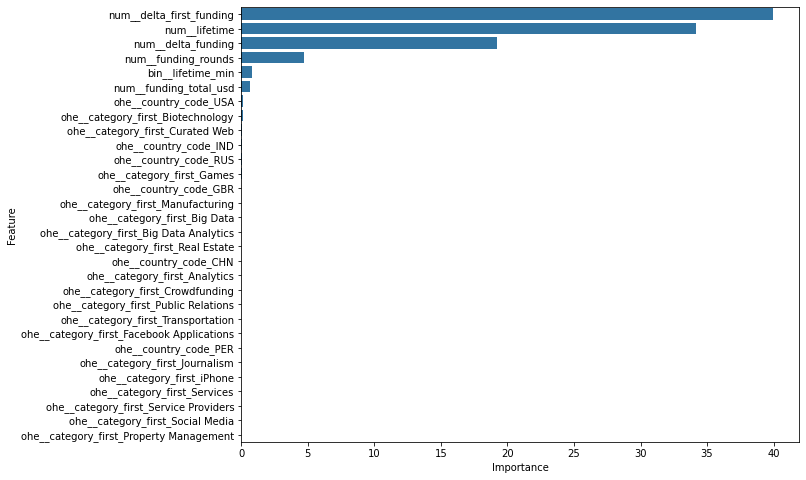

In [83]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')

**Самыми значимыми признаками оказались:**
- delta_first_funding разница между первым финансированием и датой основания
- lifetime срок продолжительности существования стартапа
- delta_funding разница между последним и первым финансированием
- funding_rounds количество раундов финансирования
- lifetime_min минимальное количество дней существования стартапа
- funding_total_usd финансирование стартапа

In [84]:
data_preprocessor.fit(X_train, y_train)
X_train_p = pd.DataFrame(data_preprocessor.transform(X_train), columns = feature_names)
# выводим предсказанные значения тренировочной выборки
X_test_p = pd.DataFrame(data_preprocessor.transform(X_test), columns = feature_names)

In [85]:
X_test_p

,x0_ARE,x0_ARG,x0_AUS,x0_AUT,x0_BEL,x0_BGR,x0_BRA,x0_CAN,x0_CHE,x0_CHL,...,x1_iOS,x1_iPad,x1_iPhone,x1_infrequent_sklearn,funding_total_usd,funding_rounds,lifetime,delta_first_funding,delta_funding,lifetime_min
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.073144,-0.538859,0.167585,-0.357442,-0.503179,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.078010,-0.538859,-0.197427,-0.594990,-0.503179,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.087346,0.188662,-0.859478,-0.616200,-0.320202,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.116230,1.643703,0.748160,-0.596808,2.306833,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.062982,-0.538859,1.428368,0.807878,-0.503179,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.089724,-0.538859,-0.391107,-0.420465,-0.503179,0.0
13121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.078010,-0.538859,-0.441855,-0.209580,-0.503179,0.0
13122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.056626,0.916183,-0.101984,-0.891926,0.992589,0.0
13123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.088999,0.188662,-0.642519,-0.251999,-0.447996,0.0


In [86]:
randomized_search.best_estimator_.named_steps['models'].fit(X_train_p, y_train)

## Вывод

### Общий анализ данных:<br>
Были изучены данные о стартапах.<br>
Данные содержат информацию о финансировании стартапа (раундах и сумме), датах основания и финансирования, продолжительность существования стартапа и его категорию, географию.<br>
Целью исследования было:
- разработать модель для предсказания успешности стартапа (закроется или нет).


### Предобработка данных:
В данных о клиентах магазина не было обнаружено явных дубликатов, пропуски в числовых данных заполнили.<br>
Всего 50 тыс. строк в тренировочных данных и 13 тыс. в тестовых.


### Исследовательский анализ:
Проанализировали признаки и создали новые:
- бинарный признак большой объем финансирования (1,е сли финансирование более 1570000000)<br>
- бинарный признак минимальная продолжительность жизни стартапа lifetime_min (1, если продолжительность менее 730 дней)<br>
- числовой признак lifetime = дата закрытия - дата основания<br>
- числовой признак delta_first_funding  = дата первого финансирования и дата основания<br>
- числовой признак delta_funding = дата последнего финансирования - дата первого финансирования<br>

### Использование пайплайнов:
Создали пайплайн, который обрабатывает данные и строит модель классификации.
К данным применили методы масштабирования(StandardScaler(), MinMaxScaler()) и кодирования(OneHotEncoder).<br>
Применяли модели:<br>
    - KNeighborsClassifier с параметром n_neighbors<br>
    - DecisionTreeClassifier с параметрами max_depth, max_features<br>
    - LogisticRegression с параметром C<br>
    - SVC с параметром kernel<br>
    - CatBoostClassifier с параметрами learning_rate, iterations, max_depth<br>
Использовали RandomizedSearchCV для подбора гиперпараметров моделей. Отбирали 50 самых важных признаков.<br>
<br>
Выбрали метрику F1.<br>
<br>
Наилучшей оказалась модель **CatBoostClassifier с параметрами learning_rate=0.05, iterations=500, depth=6.**


### Анализ важности признаков:
**Самыми значимыми признаками оказались:**
- delta_first_funding разница между первым финансированием и датой основания
- lifetime срок продолжительности существования стартапа
- delta_funding разница между последним и первым финансированием
- funding_rounds количество раундов финансирования
- lifetime_min минимальное количество дней существования стартапа
- funding_total_usd финансирование стартапа